In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/Codes_divers/PlantBiophysics-paper-Quarto/notebooks/evaluation/Fig6`


In [2]:
### A Pluto.jl notebook ###
# v0.19.23

using Markdown
using InteractiveUtils

# This Pluto notebook uses @bind for interactivity. When running this notebook outside of Pluto, the following 'mock version' of @bind gives bound variables a default value (instead of an error).
macro bind(def, element)
    quote
        local iv = try Base.loaded_modules[Base.PkgId(Base.UUID("6e696c72-6542-2067-7265-42206c756150"), "AbstractPlutoDingetjes")].Bonds.initial_value catch; b -> missing; end
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : iv(el)
        el
    end
end



@bind (macro with 1 method)

# PlantBiophysics.jl evaluation at daily scale


In [3]:
begin
	using PlantBiophysics, PlantSimEngine, PlantMeteo
	import PlantBiophysics.gs_closure
	using DataFrames, CSV, Downloads
	using Statistics
	using MonteCarloMeasurements
	using CairoMakie, Colors
	using Dates
	using PlutoUI
	using Interact
	unsafe_comparisons(true)
	constants = Constants();
	nothing
end



WebIO._IJuliaInit()

┌ Info: Unsafe comparisons using the function `pmean` has been enabled globally. Use `@unsafe` to enable in a local expression only or `unsafe_comparisons(false)` to turn off unsafe comparisons
└ @ MonteCarloMeasurements /Users/arsouze/.julia/packages/MonteCarloMeasurements/4G9w2/src/MonteCarloMeasurements.jl:74



## Downloading and filtering data




The data is from Medlyn et al. (2015), see [here](https://figshare.com/articles/dataset/Tumbarumba_Gas_Exchange/1538079?file=3402641).



In [4]:
df_Medlyn = let
	df_ = read_licor6400(Downloads.download("https://figshare.com/ndownloader/files/3402638"))
	df_.Asim .= df_.Esim .= df_.Gssim .= df_.Dlsim .= df_.Tlsim .= 0. ± 0.
	transform!(
		df_,
		[:Date,:Time]=> ((x,y) -> Date.(x, dateformat"d/m/Y") .+ y) => :date
	)
	df_
end;



In [5]:
df_curves = let
	df_ = read_licor6400(Downloads.download("https://figshare.com/ndownloader/files/3402635"))
	df_.Asim .= df_.Esim .= df_.Gssim .= df_.Dlsim .= df_.Tlsim .= 0. ± 0.
	transform!(
		df_,
		:Date => (x -> Dates.format.(Date.(x, dateformat"Y/m/d"), dateformat"d/m/Y")) => :Date,
		[:Date,:Time]=> ((x,y) -> Date.(x, dateformat"Y/m/d") .+ y) => :date
	)
	df_
end;




## Implementation of `ForcedGs`

We need a model that force the stomatal conductance to the measurement. To do so, we implement the `ForcedGs` model in PlantSimEngine.



In [6]:
begin
	"""
	    ForcedGs()
	
	A stomatal conductance model that forces the stomatal conductance to the value of `Gₛ` in the status.
	
	It usually is used to force the stomatal conductance to the value measured in the chamber.
	
	"""
	struct ForcedGs <: PlantBiophysics.AbstractStomatal_ConductanceModel 
		g0
	end

	ForcedGs() = ForcedGs(0.0)
	
	# We implement a method for gs_closure as it is used in the photosynthesis model:
	function PlantBiophysics.gs_closure(::ForcedGs, models, status, meteo=missing, constants=nothing, extra=nothing)
		# first iteration, we take measured Gs as a proxy:
		if status.A < 1e-9 
			status.Gₛ
		else
			# Then we compute it using A from the previous iteration:
			status.A / (status.Gₛ - models.stomatal_conductance.g0)
		end
	end;

	# We implement the model as a method for run!:
	function PlantSimEngine.run!(
	    ::ForcedGs,
	    models,
	    status,
	    meteo::M,
	    constants=Constants(),
		extra=nothing,
	) where {M<:PlantMeteo.AbstractAtmosphere}
	    status.Gₛ
	end
	
	# We also implement a method for run! with a gs_closure (this is called from FvCB):
	function PlantSimEngine.run!(::ForcedGs, models, status, gs_closure, extra=nothing)
	    status.Gₛ
	end
	
	# Now we declared the inputs:
	function PlantSimEngine.inputs_(::ForcedGs)
	    (Gₛ=-Inf,)
	end

	# And the outputs:
	function PlantSimEngine.outputs_(::ForcedGs)
	    (Gₛ=-Inf,)
	end
	
	@doc ForcedGs
end



```
ForcedGs()
```

A stomatal conductance model that forces the stomatal conductance to the value of `Gₛ` in the status.

It usually is used to force the stomatal conductance to the value measured in the chamber.



## User parameters

Choose a tree and a date of measurement in the dataset:


In [7]:
@bind tree PlutoUI.NumberField(minimum(df_Medlyn.Tree):maximum(df_Medlyn.Tree), default=3) 

NumberField(1:10, 3)

In [8]:
begin
    dates_tree = Dict(tree => unique(filter(x -> x.Tree == tree, df_Medlyn).Date) for tree in unique(df_Medlyn.Tree))
	@bind date Select(dates_tree[tree])
end

Select(Pair[String15("14/11/2001") => String15("14/11/2001"), String15("12/02/2002") => String15("12/02/2002"), String15("6/05/2002") => String15("6/05/2002")], missing)


!!! note
	Prefer using leaf class `1` as leaf class `0` were not fully expanded at the time of measurement.




Selecting the data:



In [9]:
df = filter(
	row -> row.Date == date && row.Tree == tree,# && row["Age Class"] == 1,
	df_Medlyn
);

In [10]:
df_curve_leaf = filter(
	row -> row.Date == date && row["Leaf Age"] == 1,
	df_curves
);




Select the columns related to the meteorology and add some uncertainty to the measurement:



In [11]:
meteo = let
	meteo_df = select(
	    df,
		:date,
	    :T => (x -> x ± 0.1) => :T,
	    :T => (x -> 40.0 ± 10.0) => :Wind,
	    :P => (x -> x ± (0.001 * x)) => :P,
	    :Rh => (x -> x ± 0.01) => :Rh,
	    :Cₐ => (x -> x ± 10.0) => :Cₐ
	)
	Weather(meteo_df, (site = "Tumbarumba",))
end;




## Fitting parameters



In [12]:
begin
	VcMaxRef,JMaxRef,RdRef,TPURef = PlantSimEngine.fit(Fvcb,df_curve_leaf)
	# g0,g1 = PlantSimEngine.fit(Medlyn,rename(df_curve_leaf, :gs => :Gₛ))
end



(VcMaxRef = 70.15156414285369, JMaxRef = 151.8701818252424, RdRef = 0.0, TPURef = 10.84776270014557, Tᵣ = 20.96488505758621)


!!! note
	`g0` and `g1` are not fitted because the dataset does not present a Gₛ~VPD curve, and the snap measurements are already used for validation. See the script for an evaluation with a forcing of Gₛ.




## Simulation

Here we simulate the full energy balance of the leaf and store 5 variables: net carbon assimilation A (μmol m⁻² s⁻¹), transpiration E (mol m⁻² s⁻¹), carbon stomatal conductance Gₛ (mol m⁻² s⁻¹), vapour pressure deficit Dₗ (kPa) and leaf temperature Tₗ (°C).



In [13]:
df_sim = let

	leaf = ModelList(
	    energy_balance=Monteith(maxiter=100),
	    photosynthesis=Fvcb(VcMaxRef=VcMaxRef, JMaxRef=JMaxRef, RdRef=RdRef, TPURef=TPURef),
	    stomatal_conductance=Medlyn(0.01, 3.42),
	    status=(
	        Rₛ=(df.PPFD ± (0.1 * df.PPFD)) / 4.57, # not / 0.48 because it is in the chamber, the source is only PAR
	        sky_fraction=1.0,
	        PPFD=df.PPFD ± (0.1 * df.PPFD),
	        d=Particles(Uniform(0.01, 0.10))
	    ),
	    type_promotion=Dict(Float64 => Particles{Float64,2000}),
	    variables_check=false
	)

	# Make the simulation:
	run!(leaf, meteo)

	# Extract the outputs:
	df_sim =
		select(
			DataFrame(leaf),
			:A => :Asim,
			:λE => (x -> x ./ (meteo[:λ] .* constants.Mₕ₂ₒ) .* 1000.0)  => :Esim,
			:Gₛ => :Gssim,
			:Dₗ => :Dlsim,
			:Tₗ => :Tlsim,
			:PPFD
		)

	df_sim
end



Row,Asim,Esim,Gssim,Dlsim,Tlsim,PPFD
,Particle…,Particle…,Particle…,Particle…,Particle…,Particle…
1,6.15 ± 0.53,0.871 ± 0.071,0.121 ± 0.01,0.425 ± 0.018,15.3 ± 0.1,149.0 ± 15.0
2,14.7 ± 0.31,2.37 ± 0.085,0.251 ± 0.0077,0.595 ± 0.053,17.9 ± 0.4,1500.0 ± 150.0
3,14.9 ± 0.45,4.41 ± 0.085,0.186 ± 0.0036,1.44 ± 0.063,25.4 ± 0.3,1510.0 ± 150.0
4,15.1 ± 0.38,4.01 ± 0.076,0.192 ± 0.0031,1.27 ± 0.056,22.0 ± 0.32,1500.0 ± 150.0
5,5.54 ± 0.49,1.73 ± 0.13,0.0723 ± 0.0057,1.38 ± 0.03,22.2 ± 0.12,149.0 ± 15.0
6,7.15 ± 0.62,1.86 ± 0.14,0.0958 ± 0.0078,1.13 ± 0.03,22.7 ± 0.12,199.0 ± 20.0



We also make a simulation forcing the stomatal conductance to the measurement:



In [14]:
df_sim_forcedGs = let
    leaf = ModelList(
        Monteith(maxiter=100),
        Fvcb(VcMaxRef=VcMaxRef, JMaxRef=JMaxRef, RdRef=RdRef, TPURef=TPURef),
        ForcedGs(),
        status=(
            Rₛ=(df.PPFD ± (0.1 * df.PPFD)) / 4.57,
            sky_fraction=1.0,
            PPFD=df.PPFD ± (0.1 * df.PPFD),
            d=Particles(Uniform(0.01, 0.10)),
            Gₛ=df.Gₛ ± 0.0,
        ),
        type_promotion=Dict(Float64 => Particles{Float64,2000}),
        variables_check=false,
    )

    # Make the simulation:
    run!(leaf, meteo)

    # Extract the outputs:
    df_ = select(
        DataFrame(leaf),
        :A => :Asim,
        :λE => (x -> x ./ (meteo[:λ] .* constants.Mₕ₂ₒ) .* 1000.0) => :Esim,
        :Gₛ => :Gssim,
        :Dₗ => :Dlsim,
        :Tₗ => :Tlsim,
        :PPFD,
    )
    df_
end



Row,Asim,Esim,Gssim,Dlsim,Tlsim,PPFD
,Particle…,Particle…,Particle…,Particle…,Particle…,Particle…
1,6.4 ± 0.56,1.35 ± 0.071,0.199,0.413 ± 0.017,15.2 ± 0.11,150.0 ± 15.0
2,16.6 ± 0.34,2.45 ± 0.14,0.261 ± 2.8e-16,0.593 ± 0.051,17.8 ± 0.38,1500.0 ± 150.0
3,19.2 ± 0.49,4.81 ± 0.14,0.208,1.42 ± 0.058,25.3 ± 0.28,1510.0 ± 150.0
4,18.8 ± 0.42,1.99 ± 0.082,0.0858,1.35 ± 0.072,22.5 ± 0.42,1500.0 ± 150.0
5,6.04 ± 0.53,1.95 ± 0.056,0.0822,1.37 ± 0.03,22.1 ± 0.13,150.0 ± 14.0
6,7.75 ± 0.66,1.25 ± 0.033,0.0618,1.16 ± 0.028,22.8 ± 0.1,200.0 ± 20.0



## Plotting results



In [15]:
"""
	plot_var(ax, var_meas, var_sim)

Make a plot for one variable.

#### Arguments

- `ax`: the figure axis
- `var_meas`: measured variable
- `var_sim`: simulated variable
"""
function plot_var(ax, var_meas, var_sim)
    line_color = Colors.RGB(([67, 101, 139] ./ 255)...)
    error_color = line_color
    point_color = Colors.RGB(253 / 255, 100 / 255, 103 / 255)
    point_fill = Colors.RGBA(253 / 255, 100 / 255, 103 / 255, 0.5)

    scatter!(
        ax,
        var_meas,
        color=point_fill,
        markersize=12,
        label="Measurement",
        strokecolor=point_color,
        strokewidth=3
    )

    lines!(
        ax,
        pmean.(var_sim),
        color=line_color,
        linewidth=2.5,
        label="Simulation ± 95% confidence interval"
    )

    errorbars!(
        ax,
        eachindex(var_sim),
        pmean.(var_sim),
        pstd.(var_sim),
        pstd.(var_sim),
        color=error_color,
        whiskerwidth=5,
        linewidth=2
    )
end



plot_var

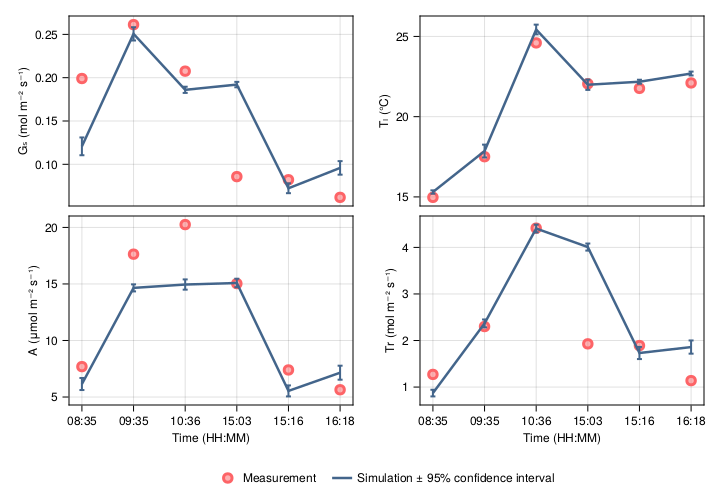

In [16]:
let
    noto_sans = assetpath("fonts", "NotoSans-Regular.ttf")
    x_labs = (eachindex(df.Tlsim), Dates.format.(df.Time, dateformat"HH:MM"))
    # size_inches = (6.7, 5)
    size_inches = (10, 7)
	size_pt = 72 .* size_inches
    fig = Figure(
        font=noto_sans,
        resolution=size_pt,
        fontsize=12,
        xminorgridstyle=true
    )

    ga = fig[1, 1] = GridLayout()

    # axDl = Axis(ga[1, 1], ylabel="Dₗ (kPa)")
    # plot_var(axDl, df.Dₗ, df_sim.Dlsim)
    axDl = Axis(ga[1, 1], ylabel="Gₛ (mol m⁻² s⁻¹)")
    plot_var(axDl, df.Gₛ, df_sim.Gssim)

    axTl = Axis(ga[1, 2], ylabel="Tₗ (°C)")
    plot_var(axTl, df.Tₗ, df_sim.Tlsim)

    hidexdecorations!(axDl, grid=false)
    hidexdecorations!(axTl, grid=false)

    axA = Axis(ga[2, 1], xlabel="Time (HH:MM)", ylabel="A (μmol m⁻² s⁻¹)")
    axA.xticks = deepcopy(x_labs)
    plot_var(axA, df.A, df_sim.Asim)

    axE = Axis(ga[2, 2], xlabel="Time (HH:MM)", ylabel="Tr (mol m⁻² s⁻¹)")
    axE.xticks = deepcopy(x_labs)
    plot_var(axE, df.Trmmol, df_sim.Esim)

    rowgap!(ga, 10)
    Legend(fig[2, 1], axDl, orientation=:horizontal, framevisible=false, padding=0.0)
    fig
end




*Figure 1. Measurement and simulation of the leaf-to-air vapor pressure deficit (Dₗ), leaf temperature (Tₗ), carbon assimilation (A) and transpiration (Tr) of a leaf in snap measurements from Medlyn et al. (2015). The photosynthesis is simulated using the model from Farquhar et al. (1980) with the analytical resolution proposed by Leuning et al. (1995) and fitted on A-Cᵢ curves data. The energy balance is simulated using the model of Monteith et al. (2013) corrected by Schymanski et al. (2017). The stomatal conductance is simulated using the model of Medlyn et al. (2011) with forced parameter fitted to match the snap measurements.*




Forcing `Gₛ` would give results such as:



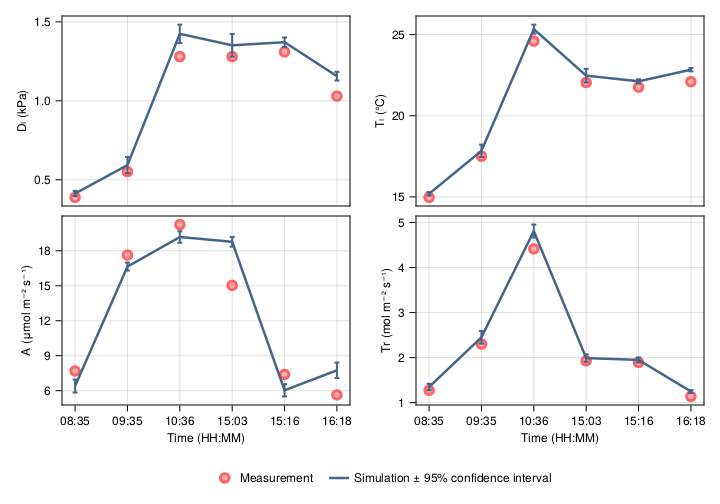

In [17]:
fig = let
    noto_sans = assetpath("fonts", "NotoSans-Regular.ttf")
    x_labs = (eachindex(df.Tlsim), Dates.format.(df.Time, dateformat"HH:MM"))
    # size_inches = (6.7, 5)
    size_inches = (10, 7)
    size_pt = 72 .* size_inches
    fig = Figure(font=noto_sans, resolution=size_pt, fontsize=12, xminorgridstyle=true)

    ga = fig[1, 1] = GridLayout()

    axDl = Axis(ga[1, 1], ylabel="Dₗ (kPa)")
    plot_var(axDl, df.Dₗ, df_sim_forcedGs.Dlsim)
    # axDl = Axis(ga[1, 1], ylabel="Gₛ (mol m⁻² s⁻¹)")
    # plot_var(axDl, df.Gₛ, df_sim.Gssim)

    axTl = Axis(ga[1, 2], ylabel="Tₗ (°C)")
    plot_var(axTl, df.Tₗ, df_sim_forcedGs.Tlsim)

    hidexdecorations!(axDl, grid=false)
    hidexdecorations!(axTl, grid=false)

    axA = Axis(ga[2, 1], xlabel="Time (HH:MM)", ylabel="A (μmol m⁻² s⁻¹)")
    axA.xticks = deepcopy(x_labs)
    plot_var(axA, df.A, df_sim_forcedGs.Asim)

    axE = Axis(ga[2, 2], xlabel="Time (HH:MM)", ylabel="Tr (mol m⁻² s⁻¹)")
    axE.xticks = deepcopy(x_labs)
    plot_var(axE, df.Trmmol, df_sim_forcedGs.Esim)

    rowgap!(ga, 10)
    Legend(fig[2, 1], axDl, orientation=:horizontal, framevisible=false, padding=0.0)
    fig
end




*Figure 2. Measurement and simulation of the leaf-to-air vapor pressure deficit (Dₗ), leaf temperature (Tₗ), carbon assimilation (A) and transpiration (Tr) of a leaf in snap measurements from Medlyn et al. (2015). The photosynthesis is simulated using the model from Farquhar et al. (1980) with the analytical resolution proposed by Leuning et al. (1995) and fitted on A-Cᵢ curves data. The energy balance is simulated using the model of Monteith et al. (2013) corrected by Schymanski et al. (2017). The stomatal conductance is forced.*



In [18]:
save("figure_day.png", fig, px_per_unit=3);




## Statistics



In [19]:
"""
    nRMSE(obs,sim)

Returns the normalized Root Mean Squared Error between observations `obs` and simulations `sim`.
The closer to 0 the better.
"""
function nRMSE(obs, sim; digits=2)
    return round(sqrt(sum((obs .- sim) .^ 2) / length(obs)) / (findmax(obs)[1] - findmin(obs)[1]), digits=digits)
end



nRMSE

In [20]:
"""
	    Bias(obs,sim)

	Returns the bias between observations `obs` and simulations `sim`.
	The closer to 0 the better.
	"""
function Bias(obs, sim, digits=4)
    return round(mean(sim .- obs), digits=digits)
end



Bias

In [21]:
"""
	nBias(obs,sim; digits = 2)

Returns the normalised bias (%) between observations `obs` and simulations `sim`.
The closer to 0 the better.
"""
function nBias(obs, sim; digits=2)
    return round(mean((sim .- obs)) / (findmax(obs)[1] - findmin(obs)[1]), digits=digits)
end



nBias

In [22]:
"""
    EF(obs,sim)

Returns the Efficiency Factor between observations `obs` and simulations `sim` using NSE (Nash-Sutcliffe efficiency) model.
More information can be found at https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient.
The closer to 1 the better.
"""
function EF(obs, sim, digits=2)
    SSres = sum((obs - sim) .^ 2)
    SStot = sum((obs .- mean(obs)) .^ 2)
    return round(1 - SSres / SStot, digits=digits)
end



EF

In [23]:
let
	df_vec = []
	vars = [:Dₗ, :Tₗ, :A, :Tr]
	for var in [df.Dₗ => df_sim_forcedGs.Dlsim, df.Tₗ => df_sim_forcedGs.Tlsim, df.A => df_sim_forcedGs.Asim, df.Trmmol => df_sim_forcedGs.Esim]
		var_ = popfirst!(vars)
		var_vec = Any[:variable => var_]
		for fn in [RMSE, nRMSE, EF, Bias, nBias]
			push!(var_vec, Symbol(fn) => fn(var.first, var.second))
		end
	push!(df_vec, (;var_vec...))
	end

	DataFrame(df_vec)
end



Row,variable,RMSE,nRMSE,EF,Bias,nBias
,Symbol,Particle…,Particle…,Particle…,Particle…,Particle…
1,Dₗ,0.0981 ± 0.024,0.107 ± 0.026,0.926 ± 0.039,0.0784 ± 0.024,0.085 ± 0.026
2,Tₗ,0.56 ± 0.13,0.0582 ± 0.014,0.968 ± 0.017,0.469 ± 0.14,0.0487 ± 0.015
3,A,2.06 ± 0.2,0.141 ± 0.014,0.864 ± 0.027,0.191 ± 0.21,0.0131 ± 0.014
4,Tr,0.202 ± 0.051,0.0617 ± 0.016,0.963 ± 0.019,0.141 ± 0.034,0.0432 ± 0.011



# References




Farquhar, G. D., S. von von Caemmerer, et J. A. Berry. 1980. « A biochemical model of
photosynthetic CO2 assimilation in leaves of C3 species ». Planta 149 (1): 78‑90.

Leuning, R., F. M. Kelliher, DGG de Pury, et E.D. Schulze. 1995. « Leaf nitrogen,
photosynthesis, conductance and transpiration: scaling from leaves to canopies ». Plant,
Cell & Environment 18 (10): 1183‑1200.

Medlyn, Belinda E., Remko A. Duursma, Derek Eamus, David S. Ellsworth, I. Colin Prentice, Craig V. M. Barton, Kristine Y. Crous, Paolo De Angelis, Michael Freeman, et Lisa Wingate. 2011. « Reconciling the optimal and empirical approaches to modelling stomatal conductance ». Global Change Biology 17 (6): 2134‑44. https://doi.org/10.1111/j.1365-2486.2010.02375.x.

Medlyn, Belinda; Pepper, David; Heather Keith (2015): Tumbarumba Gas Exchange. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1538079.v1

Monteith, John L., et Mike H. Unsworth. 2013. « Chapter 13 - Steady-State Heat Balance: (i)
Water Surfaces, Soil, and Vegetation ». In Principles of Environmental Physics (Fourth Edition),
edited by John L. Monteith et Mike H. Unsworth, 217‑47. Boston: Academic Press.

Schymanski, Stanislaus J., et Dani Or. 2017. « Leaf-Scale Experiments Reveal an Important
Omission in the Penman–Monteith Equation ». Hydrology and Earth System Sciences 21 (2): 685‑706.
https://doi.org/10.5194/hess-21-685-2017.


